In [ ]:
from google.colab import drive

# This will mount the drive to the directory /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# =========================
# Cell 1: Imports
# =========================

# If any of these fail, uncomment the pip lines and run once.
# !pip install scikit-image opencv-python-headless

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
!pip install skimage
from skimage.feature import graycomatrix
from scipy.fftpack import dct
from scipy.ndimage import laplace, binary_erosion
from math import factorial


  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


ModuleNotFoundError: No module named 'skimage'

In [4]:
# =========================
# Cell 2: Config
# =========================

IMG_SIZE = 289
CENTER = IMG_SIZE // 2   # 144 for 289x289

# Fibonacci radii (distance from center to the square edge)
fib_numbers = [3, 5, 8, 13, 21, 34, 55, 89, 144]

print("Center index:", CENTER)
print("Fibonacci radii:", fib_numbers)

# Path to ONE image for now
image_path = "dataset/Normal/11nn.png"   # <--- change this
# Class label for that image (e.g. 0,1,2 or 'class1', etc.)
class_label = 0                      # <--- change as per your dataset


Center index: 144
Fibonacci radii: [3, 5, 8, 13, 21, 34, 55, 89, 144]


In [5]:
# =========================
# Cell 3: Load + Preprocess image
# =========================

# Load image with OpenCV
img = cv2.imread(image_path)

if img is None:
    raise FileNotFoundError(f"Could not read image at {image_path}")

# Convert BGR (OpenCV) to RGB for plotting
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize to 289x289
img_rgb_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

# Convert to grayscale
img_gray = cv2.cvtColor(img_rgb_resized, cv2.COLOR_RGB2GRAY)

print("Image shape (RGB):", img_rgb_resized.shape)
print("Image shape (Gray):", img_gray.shape)

# Show original (resized) grayscale image
plt.figure(figsize=(4,4))
plt.imshow(img_gray, cmap='gray')
plt.title("Resized Grayscale Image (289x289)")
plt.axis('off')
plt.show()


[ WARN:0@81.749] global loadsave.cpp:275 findDecoder imread_('dataset/Normal/11nn.png'): can't open/read file: check file path/integrity


FileNotFoundError: Could not read image at dataset/Normal/11nn.png

In [ ]:
# =========================
# Cell A: Build square_masks and region_masks
# =========================

def build_fib_masks(img_size, fib_numbers):
    """
    Returns:
        square_masks: list of full squares for each Fibonacci radius
        region_masks: list of regions used for features:
            region 0 : inner square for fib_numbers[0]
            region i : ring between fib_numbers[i-1] and fib_numbers[i]
    """
    H = W = img_size
    cy = cx = img_size // 2

    square_masks = []
    for F in fib_numbers:
        mask = np.zeros((H, W), dtype=bool)
        top = max(0, cy - F)
        bottom = min(H, cy + F + 1)
        left = max(0, cx - F)
        right = min(W, cx + F + 1)
        mask[top:bottom, left:right] = True
        square_masks.append(mask)

    region_masks = []
    # Region 0: inner-most square
    region_masks.append(square_masks[0])

    # Regions 1..: rings between consecutive squares
    for i in range(1, len(square_masks)):
        outer = square_masks[i]
        inner = square_masks[i-1]
        ring = outer & (~inner)      # this is a FILLED band, not just 1-px outline
        region_masks.append(ring)

    return square_masks, region_masks

square_masks, region_masks = build_fib_masks(IMG_SIZE, fib_numbers)
print("Squares:", len(square_masks), "Regions:", len(region_masks))


Squares: 9 Regions: 9


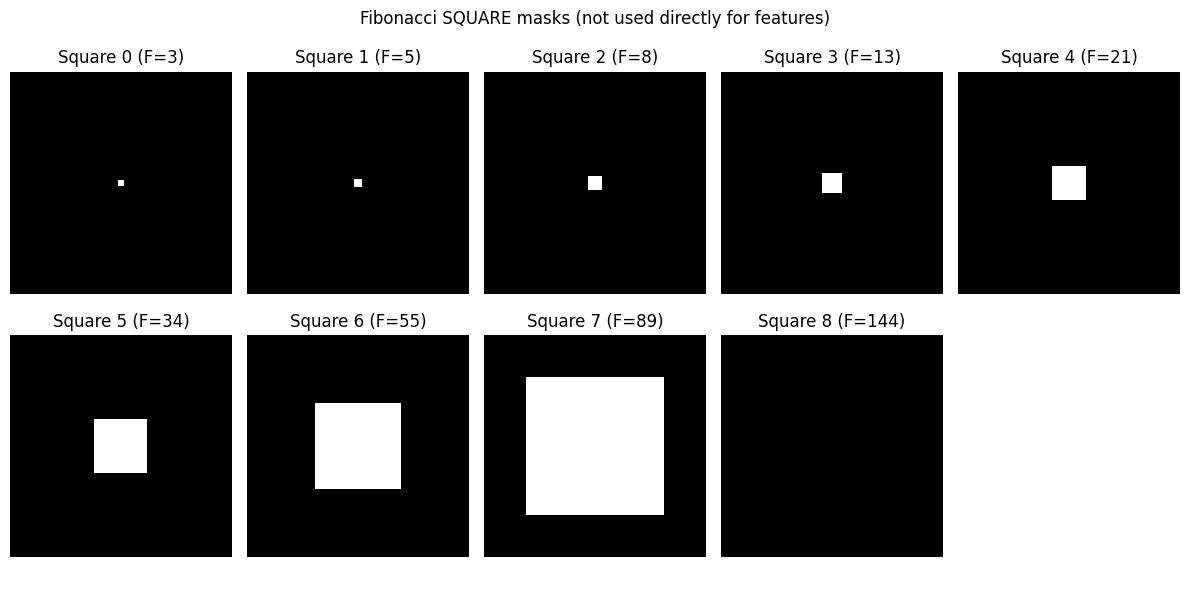

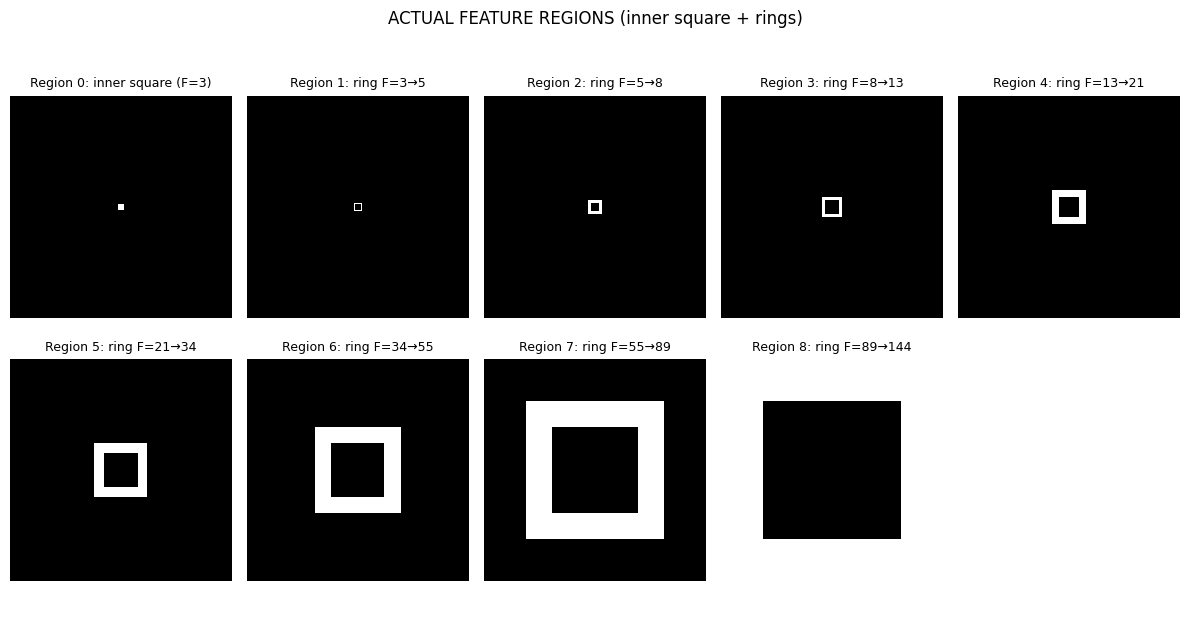

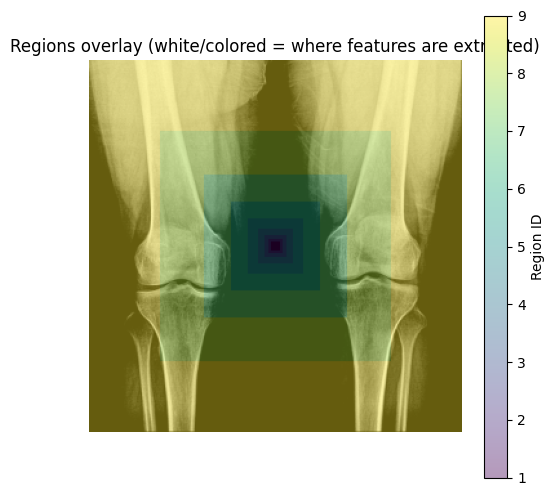

Region 0 pixel count: 49
Region 1 pixel count: 72
Region 2 pixel count: 168
Region 3 pixel count: 440
Region 4 pixel count: 1120
Region 5 pixel count: 2912
Region 6 pixel count: 7560
Region 7 pixel count: 19720
Region 8 pixel count: 51480


In [ ]:
# =========================
# Cell B: Visualization of squares and regions
# =========================

import matplotlib.pyplot as plt

num_regions = len(region_masks)

# 1) SHOW FIBONACCI SQUARES (for understanding only)
fig, axes = plt.subplots(2, (len(square_masks) + 1) // 2, figsize=(12, 6))
axes = axes.ravel()

for i, m in enumerate(square_masks):
    axes[i].imshow(m.astype(int), cmap='gray', interpolation='nearest')
    axes[i].set_title(f"Square {i} (F={fib_numbers[i]})")
    axes[i].axis('off')

for j in range(len(square_masks), len(axes)):
    axes[j].axis('off')

plt.suptitle("Fibonacci SQUARE masks (not used directly for features)")
plt.tight_layout()
plt.show()


# 2) SHOW FEATURE REGIONS = inner square + RINGS
fig, axes = plt.subplots(2, (num_regions + 1) // 2, figsize=(12, 6))
axes = axes.ravel()

for i, m in enumerate(region_masks):
    axes[i].imshow(m.astype(int), cmap='gray', interpolation='nearest')
    if i == 0:
        title = f"Region {i}: inner square (F={fib_numbers[0]})"
    else:
        title = (f"Region {i}: ring F={fib_numbers[i-1]}→{fib_numbers[i]}")
    axes[i].set_title(title, fontsize=9)
    axes[i].axis('off')

for j in range(num_regions, len(axes)):
    axes[j].axis('off')

plt.suptitle("ACTUAL FEATURE REGIONS (inner square + rings)", y=1.02)
plt.tight_layout()
plt.show()


# 3) OVERLAY REGIONS ON IMAGE
region_label_map = np.zeros_like(img_gray, dtype=np.int32)
for idx, mask in enumerate(region_masks):
    region_label_map[mask] = idx + 1   # 1..N

plt.figure(figsize=(6, 6))
plt.imshow(img_gray, cmap='gray')
plt.imshow(region_label_map, alpha=0.4)  # overlay with transparency
plt.title("Regions overlay (white/colored = where features are extracted)")
plt.axis('off')
plt.colorbar(label='Region ID')
plt.show()

# Optional: print how many pixels in each region
for i, m in enumerate(region_masks):
    print(f"Region {i} pixel count:", np.count_nonzero(m))


In [ ]:
# =========================
# Cell 6: Basic helpers
# =========================

import numpy as np

def get_roi_pixels(img_gray, mask):
    """Return intensity values inside the region as a 1D array."""
    return img_gray[mask]

def quantize_image(img_gray, levels=16):
    """
    Quantize grayscale image to given number of gray levels.
    Assumes img_gray in [0, 255].
    """
    img = img_gray.astype(np.float32)
    img_q = np.floor(img * levels / 256).astype(np.uint8)
    img_q[img_q >= levels] = levels - 1
    return img_q

def get_bounding_box(mask):
    """Return bounding box (min_row, max_row, min_col, max_col) for True mask."""
    coords = np.column_stack(np.where(mask))
    if coords.size == 0:
        return None
    min_r, min_c = coords.min(axis=0)
    max_r, max_c = coords.max(axis=0)
    # +1 on max indices for slicing
    return int(min_r), int(max_r)+1, int(min_c), int(max_c)+1


In [ ]:
# =========================
# Cell 7: Intensity + GLCM features
# =========================

def feature_median_intensity(roi_pixels):
    return float(np.median(roi_pixels)) if roi_pixels.size > 0 else 0.0

def feature_variance(roi_pixels):
    return float(np.var(roi_pixels)) if roi_pixels.size > 0 else 0.0


def feature_glcm_homogeneity(img_gray, mask, levels=16):
    """
    Approximate GLCM Homogeneity using 1D adjacency on the ROI.
    """
    roi = get_roi_pixels(quantize_image(img_gray, levels=levels), mask)
    if roi.size < 2:
        return 0.0

    # Build 1D GLCM from adjacent pairs
    glcm = np.zeros((levels, levels), dtype=np.float64)
    for i in range(roi.size - 1):
        g1 = roi[i]
        g2 = roi[i+1]
        glcm[g1, g2] += 1
        glcm[g2, g1] += 1  # make symmetric

    total = glcm.sum()
    if total == 0:
        return 0.0

    glcm /= total
    homogeneity = 0.0
    for i in range(levels):
        for j in range(levels):
            homogeneity += glcm[i, j] / (1.0 + (i - j)**2)

    return float(homogeneity)


In [ ]:
# =========================
# Cell 8: GLRLM (LRE) & GLSZM (Zone Percentage)
# =========================

def _get_1d_runs(roi_quantized):
    """
    Given 1D quantized ROI, return list of (gray_level, run_length).
    """
    if roi_quantized.size == 0:
        return []

    runs = []
    current_val = roi_quantized[0]
    run_length = 1

    for g in roi_quantized[1:]:
        if g == current_val:
            run_length += 1
        else:
            runs.append((current_val, run_length))
            current_val = g
            run_length = 1

    runs.append((current_val, run_length))
    return runs


def feature_glrlm_lre(img_gray, mask, levels=16):
    """
    GLRLM Long Run Emphasis (LRE) using 1D runs.
    """
    roi_q = get_roi_pixels(quantize_image(img_gray, levels=levels), mask)
    if roi_q.size == 0:
        return 0.0

    runs = _get_1d_runs(roi_q)
    if not runs:
        return 0.0

    numerator = 0.0
    denominator = 0.0
    for g, r in runs:
        numerator += (r ** 2)
        denominator += 1

    if denominator == 0:
        return 0.0

    lre = numerator / denominator
    return float(lre)


def feature_glszm_zone_percentage(img_gray, mask, levels=16):
    """
    GLSZM Zone Percentage (approx) = (#zones) / (#pixels in ROI)
    Using 1D runs as 'zones'.
    """
    roi_q = get_roi_pixels(quantize_image(img_gray, levels=levels), mask)
    n_pixels = roi_q.size
    if n_pixels == 0:
        return 0.0

    runs = _get_1d_runs(roi_q)
    n_zones = len(runs)

    zone_percentage = n_zones / float(n_pixels)
    return float(zone_percentage)


In [ ]:
# =========================
# Cell 9: DCT DC Energy
# =========================

from scipy.fftpack import dct

def feature_dct_dc_energy(img_gray, mask):
    """
    Compute 2D DCT on bounding box patch.
    DC Energy = (DCT[0,0])^2 calculated only on that patch.
    """
    bbox = get_bounding_box(mask)
    if bbox is None:
        return 0.0

    min_r, max_r, min_c, max_c = bbox
    patch = img_gray[min_r:max_r, min_c:max_c].astype(np.float32)

    if patch.size == 0:
        return 0.0

    # 2D DCT
    dct_y = dct(patch, norm='ortho', axis=0)
    dct_2d = dct(dct_y, norm='ortho', axis=1)

    dc = dct_2d[0, 0]
    dc_energy = float(dc ** 2)
    return dc_energy


In [ ]:
# =========================
# Cell 10: Permutation Entropy
# =========================

from math import factorial

def permutation_entropy(time_series, m=3, tau=1):
    """
    Normalized permutation entropy for 1D signal.
    Returns value in [0, 1].
    """
    ts = np.array(time_series, dtype=np.float64)
    n = ts.size
    if n < m * tau:
        return 0.0

    # Build embedding vectors
    embedded = np.array([
        ts[i : i + m * tau : tau]
        for i in range(n - (m - 1) * tau)
    ])

    # Get ordinal patterns (ranks)
    patterns = np.argsort(embedded, axis=1)

    # Count patterns
    pattern_counts = {}
    for p in patterns:
        key = tuple(p)
        pattern_counts[key] = pattern_counts.get(key, 0) + 1

    counts = np.array(list(pattern_counts.values()), dtype=np.float64)
    probs = counts / counts.sum()

    # Shannon entropy
    H = -np.sum(probs * np.log2(probs))

    # Max possible entropy
    H_max = np.log2(factorial(m))

    if H_max == 0:
        return 0.0

    return float(H / H_max)


def feature_permutation_entropy(img_gray, mask, m=3, tau=1):
    roi = get_roi_pixels(img_gray, mask)
    if roi.size == 0:
        return 0.0
    return permutation_entropy(roi, m=m, tau=tau)


In [ ]:
# =========================
# Cell 11: Laplacian variance & compactness (fixed)
# =========================

import cv2
from scipy.ndimage import binary_erosion

def feature_laplacian_variance(img_gray, mask):
    """
    Variance of Laplacian values inside the region.
    Uses uint8 patch + CV_64F Laplacian to avoid OpenCV type issues.
    """
    bbox = get_bounding_box(mask)
    if bbox is None:
        return 0.0

    min_r, max_r, min_c, max_c = bbox
    # Keep original dtype (uint8) – OpenCV likes this
    patch = img_gray[min_r:max_r, min_c:max_c]
    mask_sub = mask[min_r:max_r, min_c:max_c]

    if patch.size == 0 or np.count_nonzero(mask_sub) == 0:
        return 0.0

    # Laplacian on uint8 -> CV_64F
    lap = cv2.Laplacian(patch, cv2.CV_64F, ksize=3)
    roi_lap = lap[mask_sub]
    return float(np.var(roi_lap))


def feature_compactness(mask):
    """
    Compactness = 4*pi*Area / Perimeter^2
    Using binary erosion to approximate perimeter.
    """
    area = np.count_nonzero(mask)
    if area == 0:
        return 0.0

    # perimeter ~ boundary pixels
    eroded = binary_erosion(mask)
    boundary = mask & (~eroded)
    perimeter = np.count_nonzero(boundary)

    if perimeter == 0:
        return 0.0

    compactness = 4.0 * np.pi * area / (perimeter ** 2)
    return float(compactness)



In [ ]:
# =========================
# Cell 12: Lyapunov Exponent (approx)
# =========================

def feature_lyapunov_exponent(img_gray, mask, eps=1e-8):
    """
    Very simple Lyapunov-like measure using 1D ROI signal.
    For a more rigorous method, a full time-series Lyapunov algorithm would be needed.
    """
    roi = get_roi_pixels(img_gray, mask).astype(np.float64)
    n = roi.size
    if n < 2:
        return 0.0

    # Normalize to [0,1]
    roi_min = roi.min()
    roi_max = roi.max()
    if roi_max == roi_min:
        return 0.0
    roi_norm = (roi - roi_min) / (roi_max - roi_min)

    # Adjacent differences
    diffs = np.abs(np.diff(roi_norm)) + eps
    lyap = np.mean(np.log(diffs))

    return float(lyap)


In [ ]:
# =========================
# Cell 13: Extract all 10 features for one region
# =========================

def extract_features_for_region(img_gray, mask, levels=16):
    roi_pixels = get_roi_pixels(img_gray, mask)

    f1 = feature_median_intensity(roi_pixels)
    f2 = feature_variance(roi_pixels)
    f3 = feature_glcm_homogeneity(img_gray, mask, levels=levels)
    f4 = feature_glrlm_lre(img_gray, mask, levels=levels)
    f5 = feature_glszm_zone_percentage(img_gray, mask, levels=levels)
    f6 = feature_dct_dc_energy(img_gray, mask)
    f7 = feature_permutation_entropy(img_gray, mask, m=3, tau=1)
    f8 = feature_laplacian_variance(img_gray, mask)
    f9 = feature_compactness(mask)
    f10 = feature_lyapunov_exponent(img_gray, mask)

    return [f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]


In [ ]:
class_label = 0  # or 1/2 etc.


In [ ]:
# =========================
# Cell 14: Compute features for ALL regions of this image
# =========================

import pandas as pd

all_features = []
feature_names = []

num_regions = len(region_masks)
for r_idx, mask in enumerate(region_masks):
    region_feats = extract_features_for_region(img_gray, mask, levels=16)
    all_features.extend(region_feats)

    # Name features like R0_median, R0_variance, ...
    prefix = f"R{r_idx}"
    local_names = [
        "median_intensity",
        "variance",
        "glcm_homogeneity",
        "glrlm_lre",
        "glszm_zone_percentage",
        "dct_dc_energy",
        "permutation_entropy",
        "laplacian_variance",
        "compactness",
        "lyapunov_exponent",
    ]
    for ln in local_names:
        feature_names.append(f"{prefix}_{ln}")

print("Total features:", len(all_features))  # should be 80 (8 regions * 10)

# Create DataFrame for a single image (one row)
data = {name: [val] for name, val in zip(feature_names, all_features)}
data["class"] = [class_label]

df_single = pd.DataFrame(data)
display(df_single.head())

# Save to CSV
output_csv_path = "/content/single_image_features.csv"
df_single.to_csv(output_csv_path, index=False)
print("Saved features to:", output_csv_path)


Total features: 90


,R0_median_intensity,R0_variance,R0_glcm_homogeneity,R0_glrlm_lre,R0_glszm_zone_percentage,R0_dct_dc_energy,R0_permutation_entropy,R0_laplacian_variance,R0_compactness,R0_lyapunov_exponent,...,R8_variance,R8_glcm_homogeneity,R8_glrlm_lre,R8_glszm_zone_percentage,R8_dct_dc_energy,R8_permutation_entropy,R8_laplacian_variance,R8_compactness,R8_lyapunov_exponent,class
0,0.0,0.0,1.0,2401.0,0.020408,0.0,-0.0,0.0,1.069014,0.0,...,6505.50348,0.844737,138.421914,0.258838,471637088.0,0.758029,5941.930736,0.185394,-9.609993,0


Saved features to: /content/single_image_features.csv


In [ ]:
# =========================
# Cell 15: Dataset structure
# =========================

import os
import glob

# 1) <<< EDIT HERE: path to the folder that contains your 3 class folders
# Example: "/content/knee_data" or "D:/projects/knee_dataset"
DATASET_ROOT = "/content/drive/MyDrive/Completedata"   # <<< CHANGE THIS

# 2) <<< EDIT HERE: names of your 3 subfolders and the label you want
#    - Replace "classA", "classB", "classC" with YOUR folder names
#    - Replace 0,1,2 with labels you want to use
class_to_label = {
    "Normal": 0,   # e.g. "Normal"
    "Osteopenia": 1,   # e.g. "Mild"
    "Osteoporosis": 2,   # e.g. "Severe"
}

# ---------------------------------------------------
# BELOW THIS LINE NO NEED TO CHANGE ANYTHING
# ---------------------------------------------------

IMG_EXTS = (
    "*.png", "*.PNG",
    "*.jpg", "*.JPG",
    "*.jpeg", "*.JPEG",
    "*.bmp", "*.BMP",
    "*.tif", "*.TIF",
    "*.tiff", "*.TIFF",
    "*.jfif", "*.JFIF",
    "*.dcm", "*.DCM"
)


# build list of (image_path, label)
image_label_list = []

for class_name, label in class_to_label.items():
    class_dir = os.path.join(DATASET_ROOT, class_name)
    if not os.path.isdir(class_dir):
        print(f"WARNING: folder not found: {class_dir}")
        continue

    paths = []
    for ext in IMG_EXTS:
        paths.extend(glob.glob(os.path.join(class_dir, ext)))

    for p in sorted(paths):
        image_label_list.append((p, label))

print("Found total images:", len(image_label_list))
print("Example entries:")
for p, lab in image_label_list[:5]:
    print(lab, "->", p)


Found total images: 616
Example entries:
0 -> /content/drive/MyDrive/Completedata/Normal/10.png
0 -> /content/drive/MyDrive/Completedata/Normal/101.jpg
0 -> /content/drive/MyDrive/Completedata/Normal/104.jpg
0 -> /content/drive/MyDrive/Completedata/Normal/107.jpg
0 -> /content/drive/MyDrive/Completedata/Normal/11.jpg


In [ ]:
# =========================
# Cell 16: Per-image feature extraction
# =========================

def extract_features_for_image(image_path, class_label):
    """
    Load image, resize to IMG_SIZE, convert to grayscale,
    compute 10 features for each Fibonacci region,
    and return a dict {feature_name: value}.
    """
    # read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    # BGR -> RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # resize
    img_rgb_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

    # grayscale
    img_gray = cv2.cvtColor(img_rgb_resized, cv2.COLOR_RGB2GRAY)

    all_features = {}
    num_regions = len(region_masks)

    local_names = [
        "median_intensity",
        "variance",
        "glcm_homogeneity",
        "glrlm_lre",
        "glszm_zone_percentage",
        "dct_dc_energy",
        "permutation_entropy",
        "laplacian_variance",
        "compactness",
        "lyapunov_exponent",
    ]

    for r_idx, mask in enumerate(region_masks):
        feats = extract_features_for_region(img_gray, mask, levels=16)
        prefix = f"R{r_idx}"
        for name, val in zip(local_names, feats):
            all_features[f"{prefix}_{name}"] = val

    # add label + filename
    all_features["class"] = class_label
    all_features["filename"] = os.path.basename(image_path)

    return all_features


In [ ]:
# =========================
# Cell 17: Full dataset -> CSV
# =========================

import pandas as pd
from tqdm import tqdm    # if missing:  !pip install tqdm

all_rows = []

for img_path, label in tqdm(image_label_list, desc="Processing images"):
    try:
        feat_dict = extract_features_for_image(img_path, label)
        all_rows.append(feat_dict)
    except Exception as e:
        print(f"Error with {img_path}: {e}")

df_all = pd.DataFrame(all_rows)

print("Final DataFrame shape:", df_all.shape)
display(df_all.head())

# <<< EDIT HERE if you want a different output filename
output_csv_path = "/content/fibonacci_sequence_dataset_features.csv"
df_all.to_csv(output_csv_path, index=False)
print("Saved ALL image features to:", output_csv_path)


Processing images: 100%|██████████| 616/616 [08:07<00:00,  1.26it/s]

Final DataFrame shape: (616, 92)


,R0_median_intensity,R0_variance,R0_glcm_homogeneity,R0_glrlm_lre,R0_glszm_zone_percentage,R0_dct_dc_energy,R0_permutation_entropy,R0_laplacian_variance,R0_compactness,R0_lyapunov_exponent,...,R8_glcm_homogeneity,R8_glrlm_lre,R8_glszm_zone_percentage,R8_dct_dc_energy,R8_permutation_entropy,R8_laplacian_variance,R8_compactness,R8_lyapunov_exponent,class,filename
0,133.0,246.521449,0.979167,395.000000,0.061224,750203.500,0.917942,2867.541858,1.069014,-7.145265,...,0.961925,26645.408054,0.068978,439250848.0,0.447450,12854.471569,0.185394,-13.345818,0,10.png
1,198.0,75.246980,0.775000,7.421053,0.387755,1933688.875,0.712677,440.416493,1.069014,-3.152897,...,0.936045,4662.783596,0.114627,481722752.0,0.728792,4656.548872,0.185394,-10.977738,0,101.jpg
2,201.0,861.118701,0.556839,3.281250,0.653061,1786422.750,0.669161,7450.515618,1.069014,-2.622656,...,0.937862,4331.125674,0.111752,452230720.0,0.709334,4705.955479,0.185394,-11.287060,0,104.jpg
3,166.0,79.409413,0.760417,5.375000,0.489796,1337987.875,0.657900,443.438567,1.069014,-2.375356,...,0.936794,829.675750,0.113345,456003840.0,0.709200,6779.619927,0.185394,-10.687474,0,107.jpg
4,130.0,14.091628,0.822917,10.166667,0.367347,826800.375,0.895347,311.263640,1.069014,-3.372349,...,0.933059,920.670927,0.121601,565606592.0,0.754786,5652.179009,0.185394,-10.568668,0,11.jpg


Saved ALL image features to: /content/fibonacci_sequence_dataset_features.csv
